## Evaluation of Bayes model compared to loo
This notebook uses some datasets and compares the performance of 3 models.
- `loo`: The leave-one-subject-out model which simply averages the connectivity weights
- `bayes`: Uses the leave-one-subject-out manner but do weighted average across subjects accroding to their `coef_var`
- `bayes_vox`: Same as `bayes`, but does this integration for each voxel separately

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
from statannotations.Annotator import Annotator
import Functional_Fusion.dataset as fdata
import glob
import matplotlib.pyplot as plt

In [55]:
def plot_with_error(df, x_var, y_var, title, error='se'):
    means = df.groupby(x_var)['R_eval'].mean().sort_values(ascending=True)
    ax = sns.barplot(data=df, x=x_var, y=y_var, hue=x_var, errorbar=error, order=means.index.to_list())
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_title(title) 
    return ax, means

### Evaluation of S1 model on S2

In [56]:
dataset_list = ["MDTB", "WMFS", "Nishimoto"]
eval_data = ["MDTBs2", "WMFS02", "Nishimoto02"]
df = rm.comb_eval(models=['loo','bayes','bayes_vox'],methods=['L2reg'],eval_data=eval_data,cerebellum='MNISymC3')

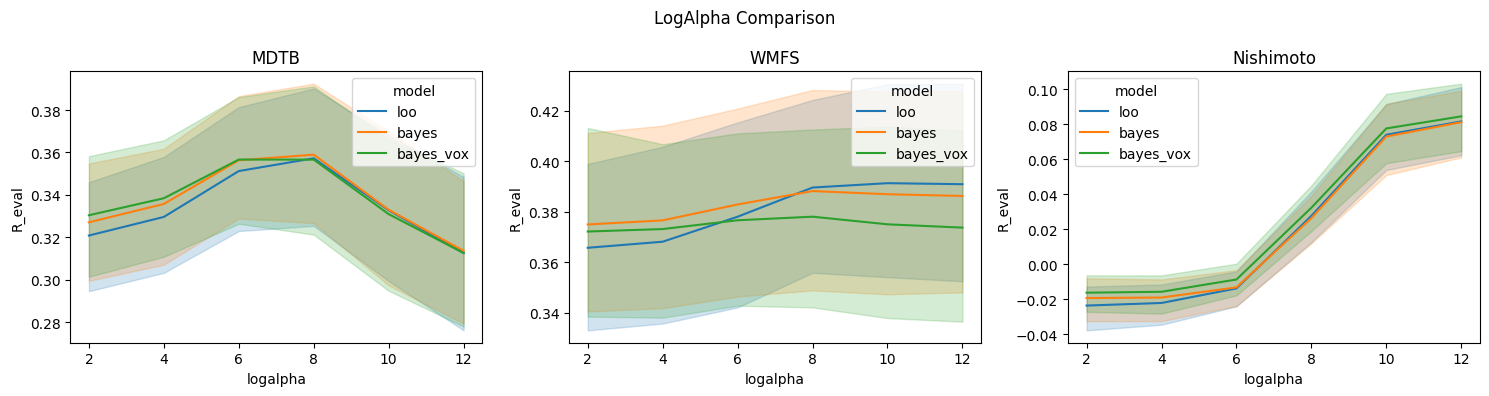

In [57]:
plt.subplots(int(np.ceil(len(dataset_list)/3)),3,figsize=(15,int(np.ceil(len(dataset_list)/3))*4))
plt.suptitle('LogAlpha Comparison')
for d,dataset in enumerate(dataset_list):
    plt.subplot(int(np.ceil(len(dataset_list)/3)),3,d+1)
    df_to_eval = df[df['eval_dataset'] == dataset]
    means = df_to_eval.groupby('model')['R_eval'].mean().sort_values(ascending=True)
    sns.lineplot(data=df_to_eval, y='R_eval', x='logalpha', hue='model', palette="tab10")
    plt.title(dataset)
plt.tight_layout()

In [59]:
A = pd.pivot_table(df,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df['isbest'] = df.logalpha.values  == bestla.loc[df.train_dataset].values.flatten()

R_eval                                                  
logalpha           2.0       4.0       6.0       8.0       10.0      12.0
train_dataset                                                            
MDTB           0.326112  0.334595  0.354744  0.357620  0.332221  0.312951
Nishimoto     -0.019615 -0.018847 -0.011797  0.028878  0.074951  0.082523
WMFS           0.370910  0.372581  0.379149  0.385254  0.384404  0.383604

,best_logalpha
train_dataset,
MDTB,8.0
Nishimoto,12.0
WMFS,8.0


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

loo vs. bayes: t-test paired samples, P_val:4.565e-02 t=-2.113e+00
bayes_vox vs. loo: t-test paired samples, P_val:6.813e-01 t=-4.160e-01
bayes_vox vs. bayes: t-test paired samples, P_val:1.638e-02 t=-2.590e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

bayes vs. loo: t-test paired samples, P_val:6.774e-01 t=-4.243e-01
bayes_vox vs. bayes: t-test paired samples, P_val:2.863e-04 t=-4.697e+00
bayes_vox vs. loo: t-test paired samples, P_val:7.954e-03 t=-3.059e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ba

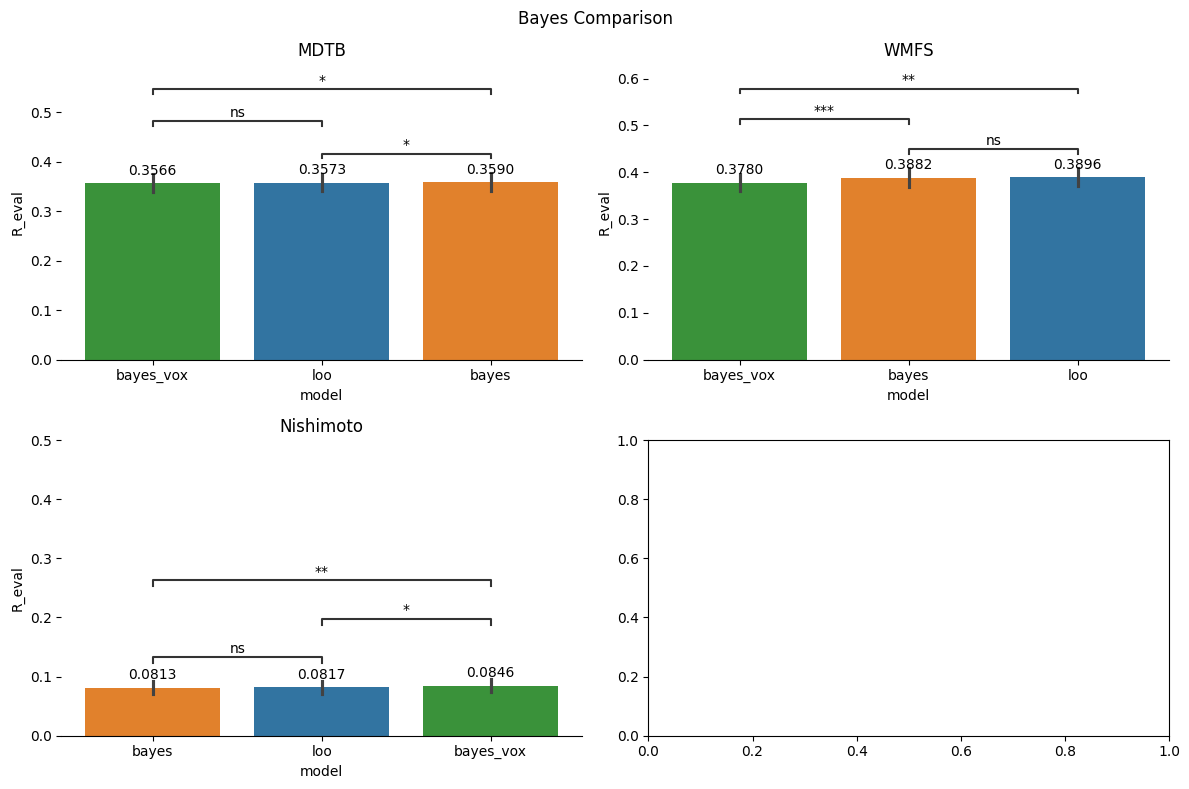

In [60]:
pairs=[('loo', 'bayes'), ('loo', 'bayes_vox'), ('bayes', 'bayes_vox')]

plt.subplots(int(np.ceil(len(dataset_list)/2)),2,figsize=(12,int(np.ceil(len(dataset_list)/2))*4))
plt.suptitle('Bayes Comparison')
for d,dataset in enumerate(dataset_list):
    plt.subplot(int(np.ceil(len(dataset_list)/2)),2,d+1)
    df_to_eval = df[(df['eval_dataset'] == dataset) & (df['isbest'])]
    ax, means = plot_with_error(df=df_to_eval, x_var='model', y_var='R_eval', title=dataset)
    plt.ylim([0, 0.5])

    # significance test
    annotator = Annotator(ax, pairs, data=df_to_eval, x='model', y='R_eval', order=means.index.to_list())
    annotator.configure(test='t-test_paired', text_format='star', loc='inside')
    annotator.apply_and_annotate()
plt.tight_layout()